In [1]:
# 必要なパッケージを呼び出す
import numpy as np
# from scipy.optimize import fsolve
# from scipy.interpolate import interp1d 
import scipy.stats as stats
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
from numba import jit

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,mu,beta,delta,alpha,b,Nl,s,prob,labor):

        self.mu   = mu          # risk aversion (=3 baseline)
        self.beta = beta        # subjective discount factor 
        self.delta = delta      # depreciation
        self.alpha = alpha      # capital's share of income
        self.b = b              # borrowing limit
        self.Nl = Nl            # number of discretized states
        self.s = s              # (exponentialed) discretized states of log labor earnings
        self.prob = prob        # transition matrix of the Markov chain
        self.labor = labor      # aggregate labor supply

In [3]:
def tauchen(N,rho,sigma,m):
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'= ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    ・Zinv: Zの定常分布
    """
    Zprob = np.zeros((N,N)) # 遷移確率の行列
    Zinv = np.zeros((N,1))  # 定常分布

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*np.sqrt(sigma**2/(1-rho**2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z = np.linspace(zmin,zmax,N)

    # グリッド所与として遷移確率を求める
    for j in range(N): # 今期のZのインデックス
        for k in range(N): # 来期のZのインデックス
            if k == 0: # Pythonのインデックスは0から始まる(ここでは0からN-1)
                Zprob[j,k] = cdf_normal((Z[k]-rho*Z[j]+w/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - cdf_normal((Z[k]-rho*Z[j]-w/2)/sigma)
            else:
                Zprob[j,k] = cdf_normal((Z[k]-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-rho*Z[j]-w/2)/sigma)

    # 定常分布を求める
    dist0 = (1/N) * np.ones(N)
    dist1 = np.copy(dist0)

    err = 1.0
    errtol = 1e-8
    iter = 1
    while err>errtol:
        dist1 = Zprob.T @ dist0
        err = sum(abs(dist0-dist1))
        dist0 = np.copy(dist1)
        iter += 1

    Zinv = np.copy(dist1)

    return Z,Zprob,Zinv 

In [4]:
def cdf_normal(x):
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    c = stats.norm.cdf(x,loc=0,scale=1)

    return c

In [5]:
@jit
def aiyagari_vfi2(mu,beta,delta,alpha,b,Nl,s,prob,r):
# def aiyagari_vfi2(m,r):
    """
    ---------------------------------------------------------
    === Computes Aggregate Savings given Interest Rate r ===
    ---------------------------------------------------------
    <input>
    ・m: model structure that contains parameters
    ・r: interest Rate
    <output>
    ・meank: aggregate savings given interest rate 
    ・kfun:  policy function
    ・gridk: asset grid(state)
    """

    # write wage as a function of interest rate
    # wage = (1-m.alpha)*((m.alpha/(r+m.delta))**m.alpha)**(1/(1-m.alpha))
    wage = (1-alpha)*((alpha/(r+delta))**alpha)**(1/(1-alpha))

    # borrowing limit
    if r <= 0.0:
        # phi = m.b
        phi = b
    else:
        # phi = min(m.b,wage*m.s[0]/r)
        phi = min(b,wage*s[0]/r)

    # -phi is borrowing limit, b is adhoc
    # the second term is natural limit

    # capital grid (need define in each iteration since it depends on r/phi)
    Nk = 300                                     # grid size for STATE 
    maxK = 20                                    # maximum value of capital grid
    minK = -phi                                  # borrowing constraint
    curvK = 2.0

    gridk = np.zeros(Nk)
    gridk[0] = minK
    for kc in range(1,Nk): # index
        gridk[kc]=gridk[0]+(maxK-minK)*((kc)/(Nk-1))**curvK



    Nk2 = 800                                     # grid size for CONTROL
    gridk2 = np.zeros(Nk2)
    gridk2[0] = minK
    for kc in range(1,Nk2): # index
        gridk2[kc]=gridk2[0]+(maxK-minK)*((kc)/(Nk2-1))**curvK


    # =================================================== #
    #  SPLIT GRID in gridk2 TO NEARBY TWO GRIDS IN gridk  #
    # =================================================== #
    
    # calculate node and weight for interpolation  
    kc1vec=np.zeros(Nk2)
    kc2vec=np.zeros(Nk2)

    prk1vec=np.zeros(Nk2)
    prk2vec=np.zeros(Nk2)

    for kc in range(Nk2):

        xx = gridk2[kc]

        if xx >= gridk[Nk-1]: # index

            kc1vec[kc] = Nk-1 # index
            kc2vec[kc] = Nk-1 # index

            prk1vec[kc] = 1.0
            prk2vec[kc] = 0.0

        else:

            ind = 0 # index
            while xx > gridk[ind+1]:
                ind += 1
                if ind+1 >= Nk-1: # index
                    break

            kc1vec[kc] = ind

            if ind < Nk-1: # index

                kc2vec[kc] = ind+1
                dK=(xx-gridk[ind])/(gridk[ind+1]-gridk[ind])
                prk1vec[kc] = 1.0-dK
                prk2vec[kc] = dK

            else:

                kc2vec[kc] = ind
                prk1vec[kc] = 1.0
                prk2vec[kc] = 0.0


    # initialize some variables
    kfunG = np.zeros((Nl,Nk))       # new index of policy function 
    kfun = np.zeros((Nl,Nk))        # new index of policy function 
    # kfun = np.zeros_like(kfunG)      # policy function   
    v = np.zeros((Nl,Nk))           # old value function
    tv = np.zeros((Nl,Nk))          # new value function
    # tv = np.zeros_like(kfunG)        # new value function
    kfunG_old = -1*np.ones((Nl,Nk)) # old policy function 

    err     = 10   # error between old policy index and new policy index
    maxiter = 2000 # maximum number of iteration 
    iter    = 1    # iteration counter

    while (err > 0) & (iter < maxiter):

        # tabulate the utility function such that for zero or negative
        # consumption utility remains a large negative number so that
        # such values will never be chosen as utility maximizing

        for kc in range(Nk): # k(STATE)
            for lc in range(Nl): # l

                kccmax = Nk2-1 # maximum index that satisfies c>0.0 
                vtemp = -1000000 * np.ones(Nk2) # initizalization

                for kcc in range(Nk2): # k'(CONTROL)

                    # amount of consumption given (k,l,k')
                    cons = s[lc]*wage + (1+r)*gridk[kc] - gridk2[kcc] 

                    if cons <= 0.0:
                        # penalty for c<0.0
                        # once c becomes negative, vtemp will not be updated(=large negative number)
                        kccmax = kcc-1 
                        break  

                    util = (cons**(1-mu)) / (1-mu)

                    # interpolation of next period's value function
                    # find node and weight for gridk2 (evaluating gridk2 in gridk) 
                    kcc1 = int(kc1vec[kcc])
                    kcc2 = int(kc2vec[kcc])
                    
                    vpr = 0.0 # next period's value function given (l,k')
                    for lcc in range(Nl): # expectation of next period's value function
                        
                        vpr += prob[lc,lcc]*(prk1vec[kcc]*v[lcc,kcc1] + prk2vec[kcc]*v[lcc,kcc2])
                    
                    vtemp[kcc] = util + beta*vpr

                # find k' that  solves bellman equation
                t1 = np.max(vtemp[1:kccmax]) # subject to k' achieves c>0
                t2 = np.argmax(vtemp[1:kccmax])
                tv[lc,kc] = t1
                kfunG[lc,kc] = t2
                kfun[lc,kc] = gridk2[t2]

        v = np.copy(tv)
        err = np.max(np.abs(kfunG-kfunG_old))
        # print(np.array([iter,err]))
        # flush(stdout)
        kfunG_old = np.copy(kfunG)
        iter += 1

    # if iter == maxiter:
    #     print("WARNING!! @aiyagari_vfi2.jl VFI: iteration reached max: iter=$iter,err=$err")

    # calculate stationary distribution
    mea0=np.ones((Nl,Nk))/(Nl*Nk) # old distribution
    mea1=np.zeros((Nl,Nk)) # new distribution
    err=1
    errTol=0.00001
    maxiter=2000
    iter=1

    while (err > errTol) & (iter < maxiter):

        for kc in range(Nk): # k
            for lc in range(Nl): # l
                
                kcc = int(kfunG[lc,kc]) # index of k'(k,l)

                # interpolation of policy function 
                # split to two grids in gridk
                kcc1 = int(kc1vec[kcc])
                kcc2 = int(kc2vec[kcc])

                for lcc in range(Nl): # l'

                    mea1[lcc,kcc1] += prob[lc,lcc]*prk1vec[kcc]*mea0[lc,kc]
                    mea1[lcc,kcc2] += prob[lc,lcc]*prk2vec[kcc]*mea0[lc,kc]
                        
        err = np.max(np.abs(mea1-mea0))
        # print(np.array([iter,err]))
        mea0 = np.copy(mea1)
        iter += 1
        mea1 = np.zeros((Nl,Nk))

    # if iter == maxiter
    #     println("WARNING!! @aiyagari_vfi2.jl INVARIANT DIST: iteration reached max: iter=$iter, err=$err")
    # end

    meank = np.sum(mea0 * kfun)

    return meank, kfun, gridk

In [6]:
indE = 1
    # =1 plot capital demand and asset supply curves (same g-grid for state/control) 
    # =2 same as 1 but use a finer a-grid for a control 
    # =3 compute eq K and r : method 1 : search over r-grid from the bottom 
    # =4 compute eq K and r : method 2 : update new guess of r in two ways

# ===================== #
#  SET PARAMETER VALUES #
# ===================== #

mu    = 3.0             # risk aversion (=3 baseline)          x   
beta  = 0.96            # subjective discount factor 
delta = 0.08            # depreciation
alpha = 0.36            # capital's share of income
b     = 3.0             # borrowing limit

# ================================================= #
#  COMPUTE TRANSITION MATRIX OF LABOR PRODUCTIVITY  #
# ================================================= #

# ROUTINE tauchen.m TO COMPUTE TRANSITION MATRIX, GRID OF AN AR(1) AND
# STATIONARY DISTRIBUTION
# approximate labor endowment shocks with seven states Markov chain
# log(s_{t}) = rho*log(s_{t-1})+e_{t} 
# e_{t}~ N(0,sig^2)

Nl  = 7             # number of discretized states
rho = 0.6           # first-order autoregressive coefficient
sig = 0.4           # intermediate value to calculate sigma (=0.4 BASE)

# prob   : transition matrix of the Markov chain
# logs   : the discretized states of log labor earnings
# invdist: the invariant distribution of Markov chain

M = 2.0
logs,prob,invdist = tauchen(Nl,rho,sig,M)
s = np.exp(logs)
labor = s.T@invdist
print(labor)


# ============================================ #
#  CREATE CONSTRUCTER THAT CONTAINS PARAMETER  #
# ============================================ #

m = Model(mu,beta,delta,alpha,b,Nl,s,prob,labor) 
# for test
# meank, kfun, gridk = aiyagari_vfi2(m.mu,m.beta,m.delta,m.alpha,m.b,m.Nl,m.s,m.prob,0.01)


if (indE==1) | (indE == 2):
    
    # ============================================= #
    #  COMPUTE INDIVIDUAL POLICY FUNCTION AND E(a)  #
    # ============================================= #

    NR = 20
    minR = -0.03
    maxR = (1-m.beta)/m.beta - 0.001
    R = np.linspace(minR,maxR,NR)
    A = np.zeros(NR)

    for i in range(NR):
        # if indE == 1:
        #     A[i] = aiyagari_vfi1(m,R[i])[1] # to be done
        # else if indE == 2:
        start = time.time()
        meank, kfun, gridk = aiyagari_vfi2(m.mu,m.beta,m.delta,m.alpha,m.b,m.Nl,m.s,m.prob,R[i])
        A[i] = meank
        end = time.time() - start
        # print("")
        print(np.array([R[i],A[i]]))
        print(f"{end:.6f} seconds")
        # print("")

    # ========================= #
    #  COMPUTE K (DEMAND SIDE)  #
    # ========================= #

    R_K = np.linspace(0,0.05,100)
    K = m.labor*(m.alpha/(R_K + m.delta))**(1/(1-m.alpha))

1.1257073928218682
[-0.03        0.32243235]
7.941680 seconds
[-0.0262807   0.33915306]
2.469756 seconds
[-0.0225614   0.37618357]
2.607444 seconds
[-0.01884211  0.42878581]
2.875355 seconds
[-0.01512281  0.50391979]
3.080088 seconds
[-0.01140351  0.59267272]
9.713699 seconds
[-0.00768421  0.70848354]
10.566472 seconds
[-0.00396491  0.84894415]
9.853106 seconds
[-2.45614035e-04  1.02305940e+00]
11.795467 seconds
[0.00347368 1.2413402 ]
11.486796 seconds
[0.00719298 1.50670496]
12.562357 seconds
[0.01091228 1.86965202]
13.210428 seconds
[0.01463158 2.47026942]
13.902423 seconds
[0.01835088 3.035894  ]
14.310856 seconds
[0.02207018 3.63190726]
13.578850 seconds
[0.02578947 4.30586914]
15.808606 seconds
[0.02950877 4.97368787]
16.213145 seconds
[0.03322807 5.67653758]
16.872400 seconds
[0.03694737 6.44781113]
17.247929 seconds
[0.04066667 8.68885099]
16.766567 seconds


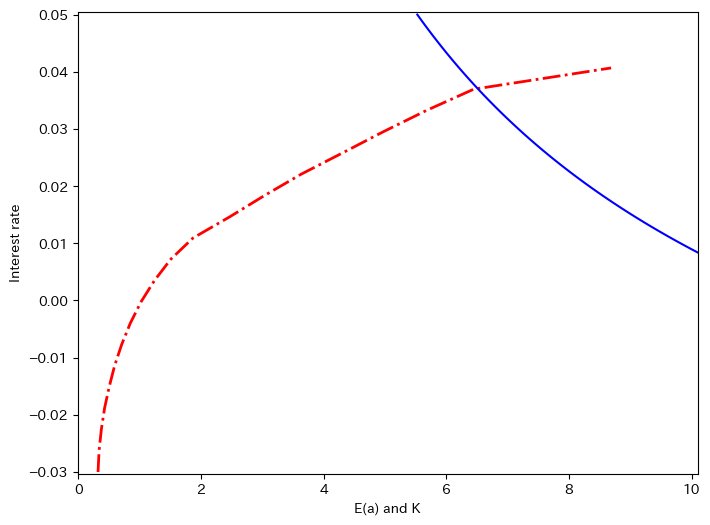

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(A,R,color="red",ls="dashdot",lw=2)
ax.plot(K,R_K,color="blue")
ax.set(xlabel="E(a) and K",ylabel="Interest rate",xlim=(0-0.01,10*1.01),ylim=(-0.03*1.01,0.05*1.01));
# savefig("fig_aiyagari.pdf")